**step0 옵션**

In [17]:
import sys, requests, urllib
import re, numpy as np, pandas as pd
from pprint import pprint
from khaiii import KhaiiiApi

# 시각화
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel


# 폰트 타입
font_path = '/home/lab543/jupyter/fonts/NotoSansCJKkr-Bold.otf'
prop = fm.FontProperties(fname=font_path)

# 워드 모양
url = 'https://www.mandarinstone.com/app/uploads/2017/09/Geometric-Cube-Decor-Ebony_Dove_White-Swatch.jpg'
mask = np.array(Image.open(requests.get(url, stream=True).raw))

# markdown text option
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

##-----함수--------
    
# 불용어 제거 함수
url = "(https?://)?(www.)?[a-zA-Z0-9./?=&-_]+[.]?[/][a-zA-Z0-9./?=&-_]+"
email = "[-_.+a-zA-Z0-9]+[@].+[.][[a-zA-Z0-9]+|[a-zA-Z0-9]+[.][a-zA-Z0-9]+]"
stop_word_reg = '([[].*]|\(.*\))'

def remove_stopword(data):
    for i in range(len(data)):
        data[i] = re.sub(url,"", data[i])
        data[i] = re.sub(email,"", data[i])
        data[i] = re.sub(stop_word_reg,"", data[i])
        data[i] = re.sub("[^가-힣a-zA-Z ]","", data[i])
    return data


# 명사 빈도세는 함수
def count_noun(data):
    t_noun = list()
    
    for _ in data:
        t_noun.extend(_)
    
    t_noun_s = pd.DataFrame(t_noun, columns=['word'])
    t_noun_f = t_noun_s.groupby('word').size().reset_index(name='count').sort_values(['count'], ascending=False).reset_index(drop=True)
    
    return t_noun_f

**step1 파일로드**

In [20]:
# 파일 로드
data = pd.read_excel('/home/lab543/jupyter/jinyoung/data/demisoda_oranC_v4.xlsx')

raw_data = data.copy()

#파일 확인
print(data['keyword'].value_counts())

data.head(2)

미린다             630
써니텐             227
펩시 탑텐           107
오란씨 믹스맥스페스티벌     62
환타 헤드            44
EDC 데미소다         27
오란씨 CM송          26
UMF 데미소다         12
Name: keyword, dtype: int64


,keyword,category,date,title,username,content,click,link,channel,site
0,EDC 데미소다,default,2019-08-30,푸드투데이 오늘 뉴스 - [이슈점검] 농민 보호 팽개친 농협 하나로마트의 '위험한 ...,푸드투데이,[푸드TV] 국회로 간 4-H 청소년 차세대 리더로 거듭나다[푸드투데이 = 홍성욱 ...,NaN,https://m.blog.naver.com/foodtoday1?Redirect=L...,default,naverBlog
1,EDC 데미소다,default,2019-08-30,[푸드투데이] 동아오츠카 데미소다 ‘EDC KOREA 2019’ 이벤트 진행,푸드투데이,동아오츠카 데미소다 ‘EDC KOREA 2019’ 이벤트 진행[푸드투데이 = 조성윤...,NaN,https://m.blog.naver.com/foodtoday1?Redirect=L...,default,naverBlog


---

**step2 분석 데이터셋 선택**

In [14]:
key = "미린다"

data = data.loc[data['keyword'].str.contains(key)].reset_index().drop(['index'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 10 columns):
keyword     630 non-null object
category    630 non-null object
date        630 non-null object
title       630 non-null object
username    630 non-null object
content     629 non-null object
click       0 non-null float64
link        630 non-null object
channel     630 non-null object
site        630 non-null object
dtypes: float64(1), object(9)
memory usage: 49.3+ KB


In [15]:
print(color.BOLD + '<키워드 체크>' + color.END)
print(data['keyword'].value_counts())

<키워드 체크>
미린다    630
Name: keyword, dtype: int64


---

**step3 불용어 제거 및 명사 추출**

In [16]:
data = data.fillna('')
texts = data['title']+data['content']

# 불용어 제거 함수 사용::remove_stopword
clean_text = remove_stopword(texts)

# 형태소 나누기
kha = KhaiiiApi()
mor = list()

for i in range(len(clean_text)):
    temp_mor = list()
    try:
        for contents in kha.analyze(clean_text[i]):
            temp = str(contents).split("\t")[1].split('+')
            temp_mor.extend(temp)
        mor.append(temp_mor)
    except:
        continue

# 명사 추출
noun = list()
n = re.compile('[ㄱ-ㅎ가-힣a-zA-Z]{2,}(?=\/NNG)|[ㄱ-ㅎ가-힣a-zA-Z]{2,}(?=\/NNP)|[ㄱ-ㅎ가-힣a-zA-Z]{2,}(?=\/SL)')

for i in range(len(mor)):
    noun.append(n.findall(str(mor[i])))
    
noun[2]

TypeError: unsupported operand type(s) for +: 'datetime.datetime' and 'str'

In [9]:
# 명사 빈도 파악
from collections import Counter
t_noun = list()
for _ in noun:
    t_noun.extend(_)
t_noun_s = pd.DataFrame(t_noun, columns=['word'])
t_noun_s.groupby('word').size().reset_index(name='count').sort_values(['count'], ascending=False).head(20)

,word,count
5247,만원,1950
7354,사랑,1021
11686,음료,682
15024,탄산,627
7351,사람,559
15537,판매,558
14597,케이코,518
5558,메뉴,517
7729,생각,475
16772,환타,455


---

**step4 단어 정제**

In [123]:
# 바꾸기
pre_noun = list()

pre_noun = [[re.sub('블록체$|^블록$|^체인$','블록체인',noun_) for noun_ in nouns] for nouns in noun]
pre_noun = [[re.sub('^비트.{0,}|.{0,}트코인$|^비트코$','비트코인',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^영업.{0,}','영업이익',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^사이버.{0,}','사이버해킹',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^힌트체.{0,}','힌트체인',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^캐리프.{0,}','캐리프로토콜',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('의원블록체','블록체인미디어협회',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^임시$','임시총회',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^건전$','건전성',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^스피$','보이스피싱',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('머니투데','머니투데이',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^자산$','가상자산',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^가상$','가상화폐',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^암호$','암호화폐',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^대포$','대포통장',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^록체인협$|^협회다양$','블록체인협회',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^산불피$','산불피해',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^국민속$','국민',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^도민환원$','도민환원제',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('.{0,}김병욱$','김병욱',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^그라운드$','그라운드X',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^시키$','해시키',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^테라루$','테라루나',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^리브$|^브라$','리브라',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^에픽세$','에픽세븐',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^오비$|^후오$|^오비코리아$','후오비',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^클레이$','클레이튼',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^프리미$','프리미어',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^포레$','포레스팅',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^에어$','에어드랍',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^세븐일$|^세븐일레$|^븐일레븐$|^븐일레$|^븐일$','세븐일레븐',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^EVENT$|^이벤트기간$','이벤트',noun_) for noun_ in nouns] for nouns in pre_noun]


# 제거
pre_noun = [[noun_ for noun_ in nouns if noun_ != "화폐"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "보이"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "통장"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "드랍"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "쪽지주"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "DHUQM"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "인거"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "는동"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "니당"] for nouns in pre_noun]

In [124]:
# 페이코인
pre_noun = [[re.sub('^페이코$|^이코인$','페이코인',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('daxpo','daxpo busan',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^탄소$','탄소섬유',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^커피$|^달콤$','달콤커피',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^tos$','티오스',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^입코드$','가입코드',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^도미$|^피자$|^피자관련$|^도미노$','도미노피자',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^이웃추$','이웃추가',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^리워드$|Reward|^리워$','리워드코드',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^신규가입시$|^가입시$|^신규$','신규가입',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^이벤트라$','이벤트',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^가입후$|^회원$','회원가입',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^실사$','실사용',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^kFC$','KFC',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^초면$','30초',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^천원$','5천원',noun_) for noun_ in nouns] for nouns in pre_noun]


pre_noun = [[re.sub('^페이코인$|^페이$','',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^페이프로토콜$|^페이프로$','',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[re.sub('^pci$|PCI|다날|^paycoin$|^payprotocol$|^프로토콜$|PayProtocol','',noun_) for noun_ in nouns] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != ""] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "GSWL"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "CUGL"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "코드"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "가입"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "코드입"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "천원지급"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "가입만"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "CTPUMAQ"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "원화"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "Code"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "기전"] for nouns in pre_noun]
pre_noun = [[noun_ for noun_ in nouns if noun_ != "webpayprotocolio"] for nouns in pre_noun]



In [125]:
# 명사 빈도 파악
from collections import Counter
t_noun = list()
for _ in pre_noun:
    t_noun.extend(_)
t_noun_s = pd.DataFrame(t_noun, columns=['word'])
t_noun_s.groupby('word').size().reset_index(name='count').sort_values(['count'], ascending=False).head(60)

,word,count
578,리워드코드,610
207,가능,422
1271,이벤트,391
1502,지급,352
1355,입력,334
896,세븐일레븐,327
501,도미노피자,320
822,사용,315
1002,신규가입,277
461,달콤커피,271


In [126]:
# 단어 탐색

w = 'BBQ'  #찾을 단어

pd.set_option('display.max_colwidth',-1)
data.loc[data['content'].str.contains(w),('title','content')]

,title,content
3,페이코인 4 500원 바로 받기 (이벤트 연장),* 안드로이드 : https://hoy.kr/wCOpW * 아이폰 : https://hoy.kr/g3lrG 위의 링크에서 페이 프로토콜 지갑을 설치하고 리워드 코드 입력하고 비번 등록하면 바로 25 pci 들어옵니다 리워드 코드 : PM3T4A9 1 pci 는 시세가 대략 171원 정도이며 25 pci 는 4 300원 정도 됩니다 추천시 1명당 20 pci 지급해 주는데 이벤트 기간이 11월 8일까지였다가 연장되었습니다 받은 코인은 후오비코리아로 코인 이체해서 시세대로 매도하여 현금화할 수 있고 그 방법이 번거로우신 분은 페이 코인 사용처에서 지갑 앱에 있는 바코드로 결제하실 수 있습니다 * 사용처 오프라인 : 세븐일레븐 달콤커피 온라인 : 도미노피자 KFC 아이템매니아 달콤커피 BBQ치킨 암호화폐로 결제하는 경험을 해보시기 바랍니다
10,혜택 종료전 리워드코드 입력만으로 5천원지급 바로 현금화 가능한 혜택받아가세요^^,[페이프로토콜 월렛 앱]을 추천합니다! 앱 가입시 아래 추천인 리워드 코드만 입력하시면 편의점 카페 등 다양한 가맹점에서 바로 사용하실 수 있는 25PCI(5천원상당 바로 현금화 가능)혜택을 드립니다! 친구와 함께 페이프로토콜 월렛의 즐거운 혜택을 받아가세요! 리워드 코드:8L40UUF BBQ KFC 도미노피자 세븐일레븐 달콤커피 등 전국 가맹점에서 월렛 앱으로 페이코인의 첫 결제를 경험하세요! https://web.payprotocol.io/install/share #페이프로토콜월렛
54,‘도미노피자·BBQ·KFC’ 파트너 늘리는 다날 페이코인 암호화폐 사업 넓힌다,http://news.zum.com/articles/56193951 ‘도미노피자·BBQ·KFC’ 파트너 늘리는 다날 페이코인 암호화폐 사업 넓힌다 통합결제 비즈니스 전문기업 다날의 페이코인[Paycoin]이 제네시스BBQ와 결제 서비스 제휴를 맺었다. 제네시스BBQ는 국내 .. news.zum.com
59,페이코인(PICCOIN) 분석 및 사용후기 이벤트,wave IT 경제 페이코인(PICCOIN) 분석 및 사용후기 이벤트 김물결 2019. 11. 7. 14:12 이웃추가 본문 기타 기능 오늘 소개해드리고자 하는 프로젝트는 페이코인(PCICOIN)입니다. ​ 상당히 인기가 많은 프로젝트이며 글로벌 페이먼트 기업 다날이 구축을 한 블록체인 기반의 결제 시스템입니다 현재 오프라인 매장에서 결제를 하는 방식은 현금 신용카드 휴대폰결제 등이 있는데 각자 장단점이 있지만 높은 결제 수수료의 단점과 긴 정상주기로 많은 가맹점 입장에서도 불편함이 있는 건 사실입니다 ​ 이런 불편함을 해결방안으로 많은 솔루션이 나왔지만 블록체인으로 해결하고자 하는 다날에서 페이프로토콜을 만들어요 ​ 강점은 다날의 가맹점 인프라를 활용을 토대로 실제 사용 가능한 암호화폐 결제를 만드는 것에 집중합니당 ​ 그래서 페이코인 분석과 사용후기 이벤트 안내로 소개해드릴게요 글로벌 페이먼트 기업 다날이란? ​ 약 5 000억 원 규모의 국내 휴대폰 결제시장 점유이며 100K+의 온/오프라인 파트너와 가맹점 보유를 하고 있습니다. ​ 다날은 2000년 7월 부터 국내최초로 상용화한 서비스이며 휴대폰 결제 시장은 04년부터 꾸준하게 성장하고 있으며 07년부터는 거래금액이 1조원이 넘어가는 규모를 자랑합니다. ​ 이제는 온라인 소액결제를 하게 된다면 무조건 다날을 이용한다고 보시면 되는 곳입니다. ​ 이러한 글로벌 페이먼트 기업 다날에서 시작한 프로젝트 페이프로토콜이라는 점에서 프로젝트 초기에 많은 사랑을 받았으며 현재도 투자자들의 관심을 가지고 있는 프로젝트입니다. 다날 주요 파트너 ? ​ 하이퍼레저 기반의 Pay Coin으로 세븐일레븐 달콤커피 KFC 도미노피자 등에서 결제가 가능합니다. ​ 기존 결제 솔루션 블록체인 프로젝트들과 다른 점은 실제로 결제가 가능한 프로젝트는 없었다는 점에서 매력적인 포인트라고 보이며 확실히 대기업 다날의 쌓아온 인지도일지 몰라도 거대 파트너사들로 구성되어 있습니다. ​ 지금이라도 가서 도미노피자를 시키거나 세븐일레븐에서 구매를 할 수가 있다는 것이죠. 저같은 경우에는 세븐일레븐과 달콤커피를 자주 가고는 합니다. 결제 과정? ​ 페이코인 사용을 하기 위해서는 먼저 페이프로토콜 어플을 다운받아 내 개인지갑으로 페이코인을 전송합니다. 그렇게 오프라인이나 온라인에서 결제하고 싶을때 바코드 주소 큐알코드를 찍어서 구매를 하면 되는 구조입니다. ​ 결제 사용자는 결제 참여에 따른 다양하게 암호화폐 리워드를 받을 수가 있으며 암호화폐를 활용을 해서 낮은 수수료구현이 가능합니다. ​ 가맹점 혜택으로는 간편한 통합 결제 시스템 제공과 낮은 수수료율과 실시간 정상이 가능하다는 점이 엄청난 매리트입니다. ​ 그리고 다양한 마케팅 프로모션을 진행하기 때문에 가맹점 입장에서는 아주 긍정적이라는 것입니다. ​ 이러한 구조는 가맹점 고객 둘의 입장에서 모두가 윈윈하는 구조라 수요가 있을 수밖에 없다는 것이죠. 접근성 ​ 페이프로토콜은 블록체인 기술의 이점을 제대로 이용했다고 보시면 되고 고객과 가맹점 모두 원활한 환경에서 결제를 이루어지게 제공을 하는 역할을 한다고 보시면 됩니다. ​ 페이프로토콜은 가맹점 POS 시스템의 페이코인 결제를 위해서 API와 SDK를 제공하고 있으며 POS 사용이 불가능한 가맹점은 스마트폰 기반으로 하는 모바일 POS 시스템도 지원을 하고 있어서 페이프로토콜이 제공하는 솔루션에서 모든 결제가 가능하도록 하는 것이죠. ​ 확실히 이러한 부분을 본다면 기술력이 상당히 있는 프로젝트라는 것이 느껴지나요? ​ 페이앱 사용후기 ​ 지금 기준으로 PCI코인은 175원 기준이며 제 지갑에는 14 419원이 들어있습니다. ​ 플랫폼 안에서는 송금하기 송금받기 QR스캔이 가능하며 실제로 오프라인 매장에서 사용할 때는 페이코인으로 할게요라며 바코드를 보여주시면 매장 직원분께서 바코드를 찍어서 결제를 해줍니다. ​ 이 과정은 10초 안에 거래가 완료가 되는 것을 볼 수가 있었습니다 세븐일레븐 사용후기 ​ 저는 세븐일레븐에서 페이코인 어플을 다운받아서 결제를 해보았는데요 ! ​ 제가 좋아하는 과자 껌을 고르고 직원분께 드리고 페이코인으로 결제해주세요 라고 하니 바로 포스기에 뭐를 클릭하더니 바로 바코드를 찍어주시고 결제가 되었습니다. 저는 아이폰11pro를 쓰고 있는데 Face ID도 지원을 하는 것도 확인이 가능하십니다 ​ 바코드 찍으니 3초만에 결제완료 창이 뜨면서 2 400원 결제했다는 문구도 나와서 신기했습니당 이러한 이벤트와 빠른 결제 시스템 사용처의 확장으로 페이코인의 미래는 상당히 밝다는 생각을 가지고 있네요. 블록체인 프로젝트들 중에 로드맵에 맞추어 진행이 되고 있는 프로젝트라는 점 그리고 현재 후오비 거래소 지닥에서 거래가 되고 있습니다. 이벤트 ? ​ 현재 페이프로토콜 어플을 다운받아서 리워드코드 입력을 하면 약 5000원 상당의 페이코인을 받을 수가 있으며 ​ 리워드 코드를 작성하시면 됩니다. ​ QL7QHVE ​ 그러면 이제 BBQ나 세븐일레븐 도미노피자 등에서 이용 가능합니다. 이벤트 ? ​ 세븐일레븐에서 빼뺴로를 PCI로 구매하면 50% 페이백 ​ 이벤트 기간 : 11월 1일 ~ 11월 7일 ​ 페이백 한도 : 최대 만원 상당의 PCI ​ 페이백 일정 : 19년 12월 말 ​ 호빵 구매 시 50% 페이백 ​ 이벤트 기간 : 11월 1일 ~ 11월 30일 ​ 최대 만원 상당의 PCI ​ 페이백 일정 : 12월 말 ​ ​ 페이코인 공식 홈페이지 대한민국 대표코인 페이코인 공식 홈페이지 입니다. pay-coin.co.kr PayProtocol 공식채팅방 #3 (0405) #페이프로토콜 #payprotocol #PCI #다날 #danal #달콤커피 #blockchain #payment open.kakao.com 김물결 암호화폐 시장흐름 분석 www.youtube.com ​
60,오늘끝나요!! 5천원 즉시주는 이벤트 무조건 받아가세용❤️,👍👍👍👍👍 내일 마감이니 현금 5000원 꼭 받으세요!! 토스보다 쉽고 빠르게 돈벌기!! 페이프로토콜 앱 다운시 현금 5 000원 지급! *30초면

---

**step5 TF-IDF**

In [127]:
# 자료 형태 변환하기
clean_noun_unlist = [[" ".join(nouns)] for nouns in pre_noun]
clean_noun_sr = pd.Series((i[0] for i in clean_noun_unlist)) 

# 7단계 - 불용단어 및 중요단어 살펴보기
tfidf = TfidfVectorizer(max_features = 100, max_df=0.95, min_df=0, ngram_range=(1,3)).fit(count_noun(pre_noun))

#generate tf-idf term-document matrix
A_tfidf_sp = tfidf.fit_transform(clean_noun_sr)
max_value = A_tfidf_sp.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
tfidf_dict = np.array(tfidf.get_feature_names())

print("가장 낮은 tfidf를 가진 특성:\n", tfidf_dict[sorted_by_tfidf[:50]])
print("가장 높은 tfidf를 가진 특성:\n", tfidf_dict[sorted_by_tfidf[-50:]])

가장 낮은 tfidf를 가진 특성:
 ['kfc 도미노피자' '필수 리워드코드 입력' '리워드코드 확인 리워드코드' '리워드코드 확인' '도미노피자 실사용'
 '가능 보상 획득' '도미노피자 실사용 가능' '보상 획득' 'kfc 도미노피자 도미노피자' '전국' '리워드코드 복사'
 '달콤커피 전국' '달콤커피 달콤커피 전국' '달콤커피 전국 가맹점' '실사용 가능' '전국 가맹점' '출금 가능'
 '출금 가능 보상' '실사용 가능 지급' '지급 출금 가능' '가능 지급 출금' '가능 보상' '지급 출금' '대상'
 '대상 이벤트 진행' '신규가입 회원가입 대상' '회원가입 대상' '대상 이벤트' '회원가입 대상 이벤트' '실사용'
 '세븐일레븐 즉시 사용' '세븐일레븐 즉시' '입력 리워드코드' '결제 경험' '필수 리워드코드' '입력 필수 리워드코드'
 '리워드코드 입력 필수' '다운로드 신규가입' '도미노피자 도미노피자' '경험' '가능 지급' '세븐일레븐 달콤커피'
 '도미노피자 세븐일레븐' '도미노피자 세븐일레븐 달콤커피' '세븐일레븐 달콤커피 달콤커피' '월렛 결제' '입력 필수' '복사'
 '신규가입 리워드코드' '즉시 지급']
가장 높은 tfidf를 가진 특성:
 ['가맹점' '가맹점 사용' '신규가입 리워드코드 입력' '확인 리워드코드' '이벤트 진행' '가맹점 사용 가능'
 '세븐일레븐 kfc' '즉시 사용' '리워드코드 입력' '회원가입 확인' '신규가입 회원가입 확인' '추천 이벤트'
 '신규가입 회원가입' '필수' '사용 가능' '출금' '달콤커피 달콤커피' '도미노피자' '입력' '신규가입' '즉시' '혜택'
 '토스' '5천원' '가능' '월렛' '진행' '다운로드' '확인' '현금' 'bbq' '회원가입' 'kfc' '무료' '방법'
 '보상' '획득' '지급' '달콤커피' '설치' '가상화폐' '편의점' '정답' '이벤트' '코인' '사용' '추천' '세븐일레븐'
 '결제' '리워드코드']


In [128]:
# 낮은 tf-idf 제거
pre_noun = [[noun_ for noun_ in nouns if noun_ not in list(tfidf_dict[sorted_by_tfidf[:50]])] for nouns in pre_noun]

---

**step6 topic 개수 파악**

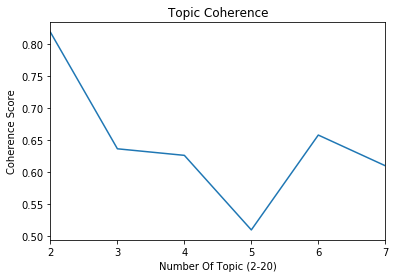

In [129]:
# 바이그램
bigram = gensim.models.Phrases(pre_noun)
bigram_model = gensim.models.phrases.Phraser(bigram)
bigram_doc = [bigram_model[nouns] for nouns in pre_noun]
# trigram = gensim.models.Phrases(bigram[pre_noun])
# trigram_model = gensim.models.phrases.Phraser(trigram)

# Create Corpus: Term Document Frequency
id2word = corpora.Dictionary(bigram_doc)
corpus = [id2word.doc2bow(doc) for doc in bigram_doc]

# 최적 개수 그래프
coherence_score = []
k = []

for i in range(2,8):
    model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics=i, passes=30, iterations=200)
    coherence_model = CoherenceModel(model, texts = bigram_doc, dictionary = id2word, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    #print('n=',i,"Score: ",coherence_lda)
    coherence_score.append(coherence_lda)

for i in range(2,8):
    k.append(i)

x = np.array(k)
y = np.array(coherence_score)
plt.title('Topic Coherence')
plt.plot(x,y)
plt.xlim(2,7)
plt.xlabel('Number Of Topic (2-20)')
plt.ylabel('Coherence Score')
plt.show()

---

**step7 LDA모델로 topic 뽑기**

In [130]:
num_topics = 6      #<<<<<<----------------------------------------------------------------위 그래프 보고 수정

# Create Dictionary
id2word = corpora.Dictionary(pre_noun)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in pre_noun]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=30,
                                           per_word_topics=True)

topics = lda_model.show_topics(formatted=False)
topics

[(0,
  [('코인', 0.05892615),
   ('후오비', 0.05846328),
   ('입금', 0.041279867),
   ('현금', 0.03605297),
   ('상당', 0.022977555),
   ('참고', 0.022748297),
   ('가상화폐', 0.020747298),
   ('홍보', 0.01964278),
   ('송금', 0.019586015),
   ('서비스', 0.018316781)]),
 (1,
  [('블로그', 0.03135347),
   ('기능', 0.025684223),
   ('기타', 0.023301432),
   ('이웃추가', 0.023243241),
   ('본문', 0.023243241),
   ('상장', 0.020332944),
   ('정보', 0.014590784),
   ('생각', 0.013306637),
   ('OK', 0.013175533),
   ('포인트', 0.012558992)]),
 (2,
  [('주소', 0.04980511),
   ('인증', 0.027208103),
   ('메뉴', 0.027042972),
   ('신청', 0.022979828),
   ('가상자산', 0.02200371),
   ('krw', 0.021407641),
   ('모양아이콘', 0.021407641),
   ('상단', 0.021407641),
   ('절차', 0.021407641),
   ('한후', 0.021407641)]),
 (3,
  [('리워드코드', 0.08597739),
   ('가능', 0.053904478),
   ('이벤트', 0.05364848),
   ('입력', 0.05111129),
   ('세븐일레븐', 0.04961439),
   ('신규가입', 0.047715105),
   ('지급', 0.039364535),
   ('도미노피자', 0.039061207),
   ('사용', 0.038687944),
   ('즉시', 0.035584245)]

**단어 찾기**

In [54]:
w = '투자'  #찾을 단어

pd.set_option('display.max_colwidth',-1)
data.loc[data['content'].str.contains(w),('title','content')]

,title,content
8,이런거 혹시 사기인가요,*질문 : 페이프로토콜 2만원 지급 이벤트 (PCI) 4500원 지급이벤트 8000원 지급이벤트카카오페이 한국투자증권 계좌만들면2만원 지급이런거혹시 사기인가요혹시 나중에 돈 빠져나가고자동결제 되고 이런건가요예전에 카카오페이 한국투자증권 계좌 신설하고2만원 받은적은 있습니다 *답변 : 저도 토스 신청하고 3000원 받았는데요공신력있는 회사에서 주관하는 것은 사기성이 없는것 같아요 ^^
11,다날 3Q 연결 누적순익 227억원 전년比 488%↑,"[아시아경제 문채석 기자]통합결제 비즈니스 전문기업 다날은 3분기 연결 누적 당기순이익 227억원을 돌파하면서 전년 동기 대비 488% 증가한 최대 실적을 달성했다고 14일 공시했다. 다날은 3분기까지 연결 누적 매출은 1425억원 영업이익 115억원 당기순이익 227억원을 기록했다고 밝혔다. 전년대비 영업이익 79.5% 당기순이익은 488%로 증가했다. 다날 관계자는 ""주력 사업 분야인 휴대폰 결제 부문 외에 신용카드 간편결제 부문의 매출이 큰 폭으로 늘고 있고 다날의 블록체인 기반의 디지털 화폐 페이코인(PCI) 서비스의 거래 증가로 매출이 본격화되고 있어 전년보다 실적이 늘었다""고 설명했다. 그는 “투자자산의 평가 하락으로 전 분기보다 이익이 줄었지만 4분기 매출액 및 이익은 최고치를 무난히 경신할 것으로 본다""고 말했다. 다날은 이달부터 삼성페이와 협업을 통한 '오프라인 휴대폰 결제 서비스'를 제공하고 있다. 다날 신규 브랜드 '다 모음' 서비스 론칭 및 기업 맞춤형 '오픈형 간편결제 서비스'를 통한 대형 가맹점 확대 등 지속적인 신사업 확장을 통한 포트폴리오 다각화를 꾀하고 있다. 다날 관계자는 ""지난해 19조원 규모 오프라인 간편결제 시장 진출을 계기로 2019년 결산 실적에 대한 기대감이 더욱 높아지고 있다""며 ""온라인과 오프라인 구분 없이 다양한 결제수단을 이용한 통합결제 플랫폼을 제공해 보다 안전하고 편리하게 이용할 수 있도록 노력하겠다""고 밝혔다. 문채석 기자 chaesoasiae.co.kr"
18,다날 페이코인으로 BBQ 치킨 결제한다,◆매일 업데이트되는 가상화폐 해외&국내 뉴스 ico 고급 투자정보 코인분석 제공 교류 카페. ◆ ☞코인네트☜ 페이코인 제너시스비비큐와 결제서비스 제휴 세븐일레븐-KFC-도미노피자…페이코인 결제가능 국내에서도 암호화폐를 이용해 대형 프랜차이즈 업체에서 치킨값을 결제할 수 있게 됐다. 암호화폐를 실물 결제에 접목하는 속도가 점점 빨라지고 있는 것이다. ☞원문보기:http://www.fnnews.com/news/201911111305278500 http://www.fnnews.com/news/201911111305278500 http://www.fnnews.com/news/201911111305278500 ★코인네트 뉴스&정보 바로가기★ ★ 코인 뉴스 ★ ★코인별 특징★ ★ 코인 분석 ★ ★유용한 정보★ 아이콘 네오 스팀 시린토큰 오미세고 코인빗 코인네스트 캐셔레스트 비트렉스 트론 차트분석 코인호재 코인가격상승 상승장 펌핑 비트코인 이더리움 에이다 가상화폐시세 업비트 비트코인전망 코빗 코인원 동전주 동전코인 블록체인 호재 리플호재 리플코인 암호화폐거래소 블록체인 XRP 암호화폐 바이낸스 코인빗 블록틱스 그로스톨코인이더리움클래식 ico 퀀텀 리플 이오스 네오 모네로 가상화폐 가상화폐시세 이더리움시세 빗썸 리플시세 가상화폐거래소 비트코인시세 비트코인 이더리움시세 비트코인골드 파워렛져 비트코인 시세 가상화폐 가상화폐 전망 암호화폐 암호화폐 전망 가상화폐ico 프리세일 프리이빗세일 가상화폐 뉴스 비트코인 전망 비트캐쉬 대쉬 빗썸 업비트 바이낸스 비트코인캐시 비트코인캐시시세
49,국제ㅡ암호화폐 뉴스모음ㅡ2019.11.11,"1. 머니그램(MoneyGram) 리플(XRP) 사용 통해 미국-멕시코 거래의 10% 처리 머니그램(MoneyGram)은 리플의 결제 솔루션인 온디맨드 유동성(ODL 이용자의 요구에 따라 네트워크를 통해 필요한 정보를 제공) 방식을 통해 미국과 멕시코 간 거래의 10%를 처리하고 있다. 머니그램 회장 겸 CEO인 알렉스 홈즈(Alex Holmes)는 싱가포르에서 열린 ‘리플 스웰 2019년 컨퍼런스’에서 이 같은 사실을 발표했다. 홈즈(Holmes)는 “머니그램은 온디맨드 유동성(ODL) 솔루션을 확장 하는 등 올해 말까지 4개 이상의 옵션으로 확대할 계획”이라고 덧붙였다. “수십억 달러를 초 단위로 송금할 수 있게 된다. 이러한 것은 리플의 온디맨드 유동성(ODL)과 머니그램 거래를 결합함으로써 가능하게 되었다.” 리플은 지난 6월 머니그램에 최대 5000만 달러까지 투자하기로 약속하며 머니그램 측은 리플(XRP)을 송금 사업에 활용하기로 합의했다. 최근 리플은 “24개 이상의 고객들이 국경을 넘는 지불을 결제하기 위해 온디맨드 유동성(ODL) 솔루션 사용에 참여하고 있다”고 발표했다. /출처 : coinpress 2. 페루의 가장 큰 은행 중 하나 국경 간 지불을 위한 XRP 사용 계획 요약 : 기존송금체계 --> xCurrent --> 현재 : xRapid(=ODL=XRP) 기업금융연구소 CFI에 따르면 인터뱅크는 페루에서 가장 큰 은행 중 하나로 이 회사는 2017년 총 매출 29억 달러를 달성했으며 자산 규모가 약 441억 달러에 달한다고 전했다. 인터뱅크라고 불리는 페루 은행 방코 인터내셔널 델 페루가 리플의 결제 메시징 시스템 ODL (기존 xRapid)을 이용해 XRP 결제 제품으로의 전환을 꽤하고 있다고 전했다. 자사의 인터뱅크 블록체인 전문가 Joisie Mantilla는 싱가포르에서 열린 리플의 Swell 컨퍼런스에서 이런 계획을 발표했다. 기존 xRapid로 알려진 온 디맨드 리퀴드 ODL는 리플의 XRP를 이용한 두 화폐 간의 브릿지로 사용할 수 있도록 설계되었다. 리플은 2018년 10월 해당 제품츨 출시 한 후 300명 이상의 고객을 끌어들였으며 그중 24건의 ODL 사용 건을 계약했다. 그는 라틴 아메리카의 국격 간 지불 인프라의 혁신이 증가함에 따라 신기술에 대한 필요성이 대두됐다고 밝혔다. “저희가 깨닫은 점은 기업 지불 및 송금 제품이 구식이라는 것입니다. 더 이상 이런 전통적인 방식으로는 경쟁하지 않으며 특히 브라질이나 미국에서 온 핀테크의 다음 단계로 페루로 잡고 번성할 목표를 삼았습니다.” /출처 : cointoday 3. 비탈릭 부테린 이더리움 2.0 세레니티 매우 낙관적 이더리움의 세레니티 업그레이드는 작업 증명인 POW에서 스테이크 증명인 POS로의 전환이며 현재 이더리움 커뮤니티에서 가장 오랫동안 기다려온 네트워크 업그레이드 중 하나다. 이더리움 2.0에 설정된 현재 예상 타임 라인에 따르면 Serenity 단계는 세 가지 주요 단계로 실행된다. 단계 0에서는 이더리움이 비콘 체인을 도입하게 되고 단계 1에서는 샤드 체인을 가져 오고 단계 2에서는 실행 계층이 설정된다. 세레니티의 첫번째 업그레이드는 2020년초에 출시될 것으로 예상되며 1단계와 2단계는 동시 릴리스가 될 것으로 예상되고 있다. 그러나 캐스퍼 컨센서스 알고리즘을 도입하게 된 변화는 현재 타임 라인이 수반하는 것보다 빨리 롤아웃될 것으로 예상되고 있다. 이같은 사실을 고려할 때 커뮤니티에서는 POS의 업그레이드가 순탄치만은 않다는 전망을 내놓고 있다. /출처 : cointoday 4. 모건크릭 창업자가 선정한 최근 암호화폐 4대 이슈 1.유럽중앙은행(ECB)이 디지털 유로를 고려하고 있다. (“ECB가 지원하는 디지털 화폐가 내년에 진전을 보일 것” 장기적으로 진행될 예정이며 아직 해결해야 할 어려움이 많다”) 2. 텐센트가 홍콩 증권선물위원회(SFC)로부터 블록체인 기반 인터넷전문은행(가상은행) 설립 승인을 획득했다 3. 미국 캘리포니아 소재 실버게이트(Silvergate) 은행이 뉴욕증권거래소에 상장했다(해당 은행은 전세계 750여 개의 암호화폐 관련 기업에 서비스를 제공). 4. 암호화폐를 지원하는 모바일 결제 서비스 업체인 스퀘어의 3분기 비트코인 매출액이 1.48억 달러를 달성(해당 수치는 동기 대비 약 115% 증가한 수준) /출처 : coi

**수정하기**

In [1]:
list1 = [('달콤커피', 0.06591089),
 ('리워드코드', 0.06271896),
 ('사용', 0.05994672),
 ('도미노피자', 0.048709456),
 ('가능', 0.045366615),
 ('입력', 0.04338702),
 ('지급', 0.043304384),
 ('현금', 0.038264968),
 ('가맹점', 0.035765782),
 ('세븐일레븐', 0.035467915),('후오비', 0.033004474)]

list2 = [('정보', 0.026594704),
   ('모바일', 0.021072008),
   ('소개', 0.020871025),
   ('포인트', 0.019381272),
   ('치킨', 0.017243465),
   ('광고', 0.016960554),
   ('이상', 0.016130276),
   ('캐시', 0.01538462),
   ('앱테크', 0.015259461),
   ('적립', 0.014907043)]

list3 = [('입금', 0.051123362),
   ('토스', 0.042110085),
   ('정답', 0.039964184),
   ('실시간정답', 0.039027404),
   ('토스행운퀴즈', 0.038220193),
   ('돈상자', 0.037734743),
   ('신규가입돈상자', 0.035666734),
   ('토스돈상자', 0.035666734),
   ('주소', 0.03316026),
   ('토스퀴즈', 0.02992019)]

list4 = [('결제', 0.07104998),
   ('추천', 0.06252807),
   ('코인', 0.05387272),
   ('상당', 0.02932423),
   ('금액', 0.028792752),
   ('기타', 0.026895098),
   ('거래소', 0.025158303),
   ('현금', 0.024831709),
   ('선택', 0.023421846),
   ('다운', 0.017403925)]

In [2]:
new_topics = list()

new_topics.append(list1)
new_topics.append(list2)
new_topics.append(list3)
new_topics.append(list4)


In [3]:
# 주제 이름 정하기(**순서 있음**)
topic = ['페이백이벤트', '현금화', '앱테크', '실물 결제']

In [121]:
# 리스트 수정이 없을때 실행

new_topics = list() 

for i in range(len(topics)):
    new_topics.append(topics[i][1])

**step7 워드클라우드**

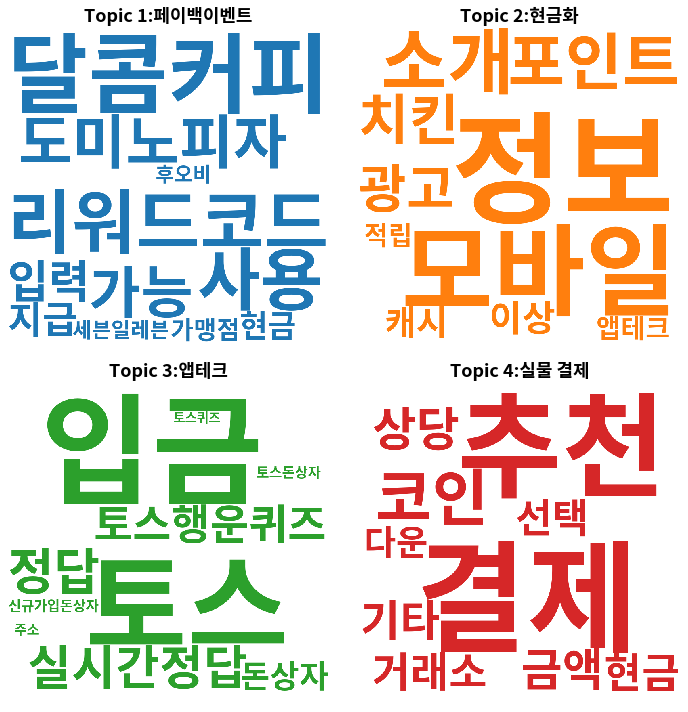

In [7]:
# 그래프 표 ***수정***
x_lim = 2
y_lim = 2


cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(font_path = font_path,
                  background_color='white',
                  width=800,
                  height=800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(y_lim, x_lim, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(new_topics[i])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1)+ ":" +topic[i], fontdict=dict(size=16), fontproperties=prop,fontsize = 18)
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()